In [1]:
import os
import warnings
base_path = os.path.abspath("../")
os.chdir(base_path)
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [6]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [7]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.57652638])

In [8]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [9]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.466394
 stars         0.405692
 quixotic      0.056295
 merciful      0.044424
 fireman       0.019247
 touch         0.001384
 clammy        0.000819
 adhesive      0.000480
 future        0.000400
 damp          0.000373
 rigid         0.000369
 playground    0.000366
 eight         0.000353
 lethal        0.000352
 barbarous     0.000350
 cute          0.000339
 sweltering    0.000317
 dependent     0.000315
 change        0.000315
 nonchalant    0.000307
 lip           0.000269
 wrap          0.000257
 shelf         0.000216
 offer         0.000194
 rain          0.000175
 dtype: float64}

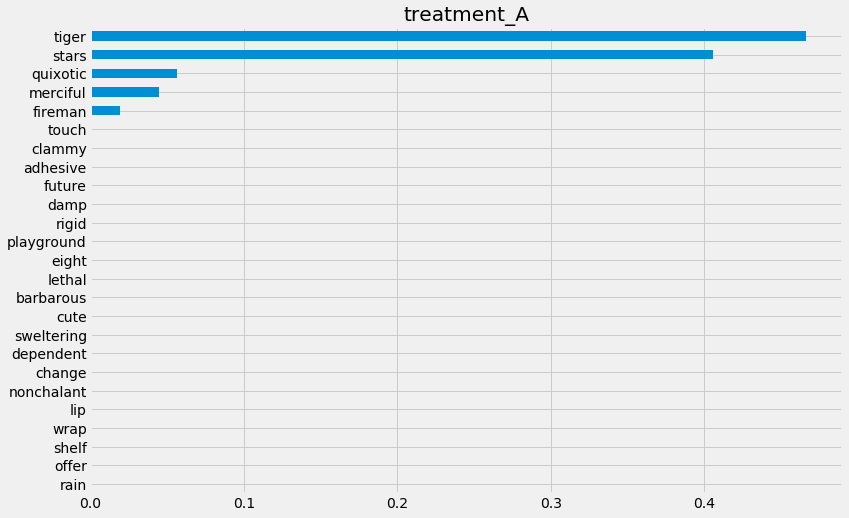

In [10]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [11]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.938470
 stars         0.838396
 quixotic      0.121493
 merciful      0.086907
 fireman       0.038455
 touch         0.001722
 dependent     0.000387
 clammy        0.000204
 adhesive      0.000197
 playground    0.000175
 barbarous     0.000065
 rigid         0.000058
 eight         0.000047
 damp          0.000037
 offer         0.000030
 shelf         0.000024
 cute          0.000021
 lip           0.000020
 rain          0.000010
 future       -0.000009
 wrap         -0.000045
 change       -0.000050
 nonchalant   -0.000055
 sweltering   -0.000115
 lethal       -0.000131
 dtype: float64}

In [12]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.6892201900482178 seconds


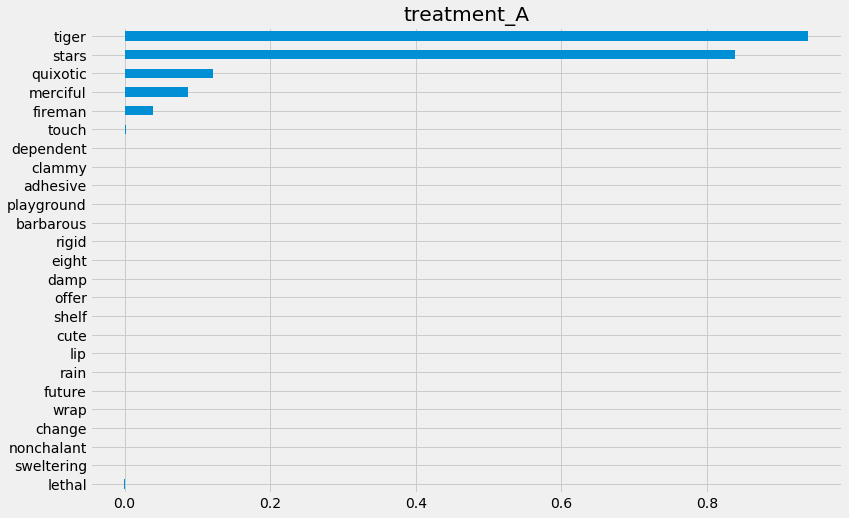

In [13]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [14]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.6840920448303223 seconds


In [15]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.938470
stars         0.838396
quixotic      0.121493
merciful      0.086907
fireman       0.038455
touch         0.001722
dependent     0.000387
clammy        0.000204
adhesive      0.000197
playground    0.000175
barbarous     0.000065
rigid         0.000058
eight         0.000047
damp          0.000037
offer         0.000030
shelf         0.000024
cute          0.000021
lip           0.000020
rain          0.000010
future       -0.000009
wrap         -0.000045
change       -0.000050
nonchalant   -0.000055
sweltering   -0.000115
lethal       -0.000131
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

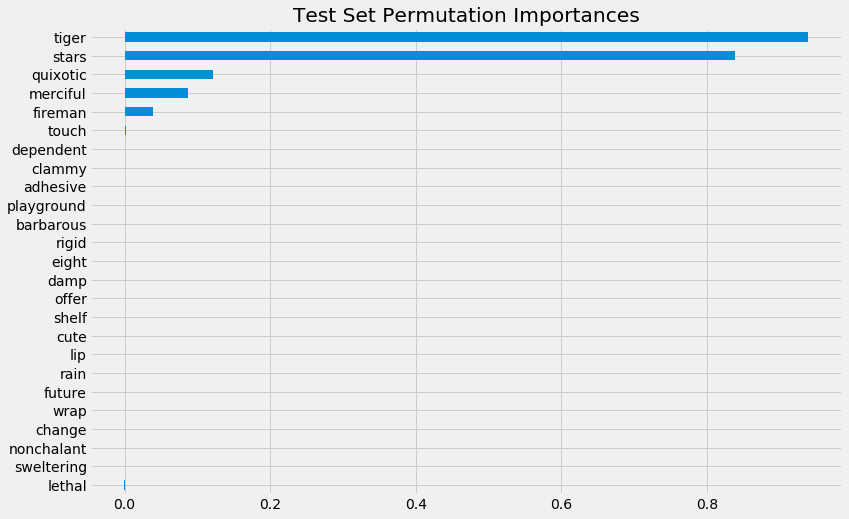

In [16]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [17]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

tiger         0.977817
stars         0.867720
quixotic      0.125296
merciful      0.090889
fireman       0.041912
touch         0.003801
dependent     0.002164
clammy        0.002008
sweltering    0.001901
cute          0.001478
lethal        0.001260
wrap          0.001231
damp          0.001206
future        0.001201
rain          0.001031
shelf         0.000976
playground    0.000888
rigid         0.000821
adhesive      0.000813
nonchalant    0.000797
change        0.000791
barbarous     0.000769
offer         0.000719
eight         0.000719
lip           0.000619
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

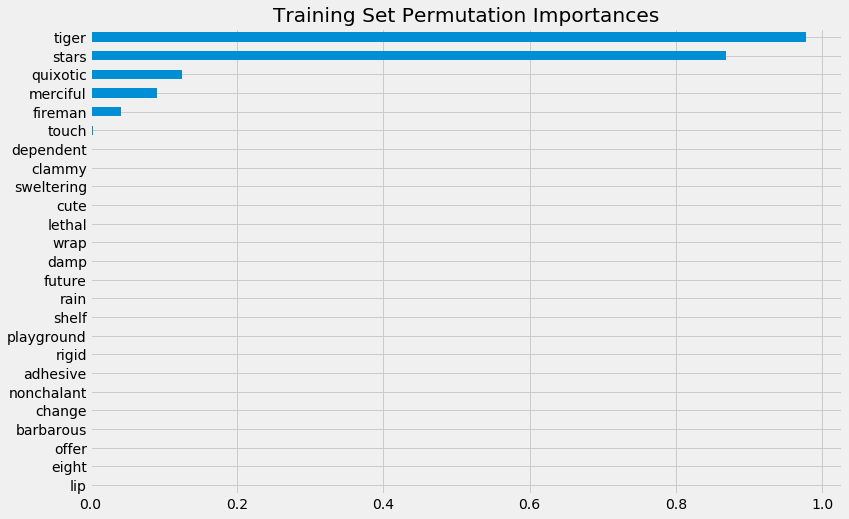

In [18]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 1.85965599e-02,  1.50524540e-01, -5.55596292e-03, ...,
          4.48446501e-04, -1.95476029e-04, -3.42248564e-03],
        [ 7.82080973e-02, -2.36391211e-01,  2.88678514e-02, ...,
         -3.70192908e-04, -3.39569059e-04,  1.22111367e-05],
        [ 9.04201505e-02,  1.59707950e-01,  1.73721268e-03, ...,
         -1.37756957e-04,  1.77684213e-04, -4.46185989e-04],
        ...,
        [-1.99286917e-01, -2.07402161e-01, -8.74781304e-02, ...,
          2.49031036e-03, -1.01702522e-03,  2.86971644e-04],
        [-1.07236468e-01,  1.09881401e-01, -3.54466649e-02, ...,
          2.69856996e-05, -6.92309733e-04, -1.94350406e-04],
        [-9.15393868e-02,  3.07062682e-01,  4.98609094e-02, ...,
         -6.94895003e-05,  7.62465467e-04, -4.42911077e-05]])}

In [20]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.13324381, 0.13797313, 0.02693165, 0.02818332, 0.01622515,
       0.00173129, 0.00043212, 0.00462018, 0.00072387, 0.00270952,
       0.00052824, 0.00024711, 0.00063725, 0.00085535, 0.00139984,
       0.00107961, 0.00083777, 0.00037895, 0.00063368, 0.00071085,
       0.00044104, 0.00115953, 0.00061382, 0.00051472, 0.00046914])

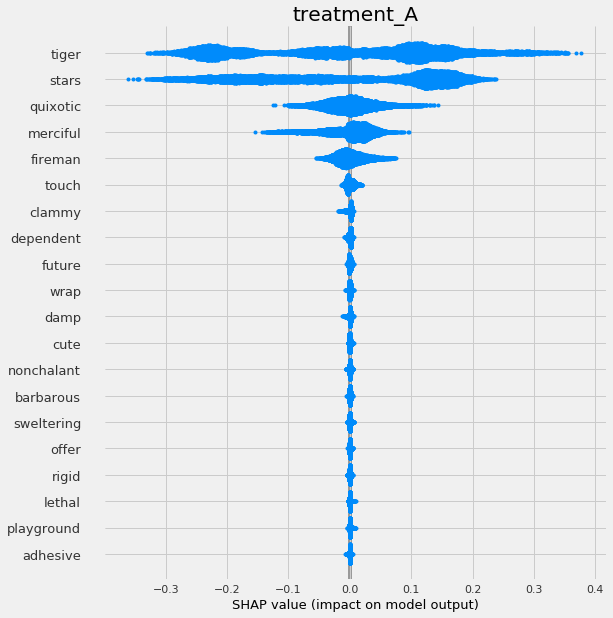

In [21]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

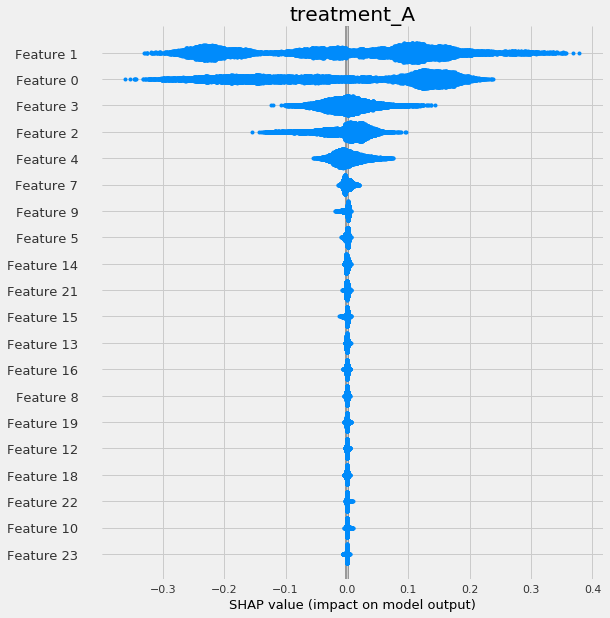

In [22]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(shap_dict=shap_slearner)

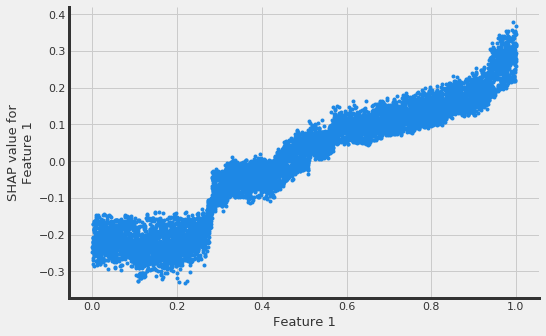

In [23]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

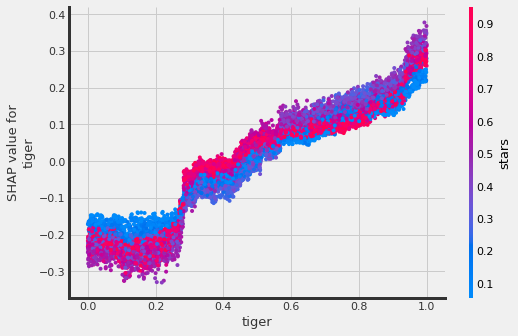

In [24]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

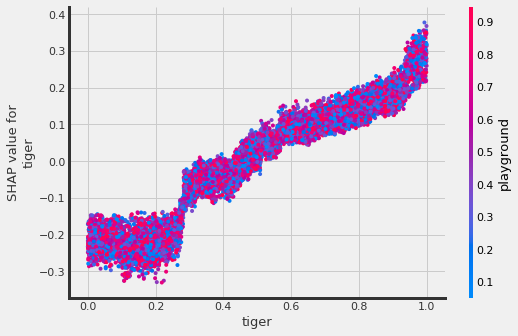

In [25]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

In [26]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.57531904]), array([0.56053703]), array([0.59010105]))

In [27]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [28]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.367077
 stars         0.298487
 quixotic      0.043473
 merciful      0.042342
 clammy        0.024813
 fireman       0.019719
 future        0.016705
 sweltering    0.016578
 lip           0.012670
 offer         0.012268
 barbarous     0.011683
 cute          0.011126
 nonchalant    0.011074
 change        0.011046
 eight         0.010876
 adhesive      0.010435
 lethal        0.010043
 damp          0.009813
 dependent     0.009771
 rigid         0.009429
 shelf         0.009045
 rain          0.009022
 playground    0.008745
 touch         0.008734
 wrap          0.005027
 dtype: float64}

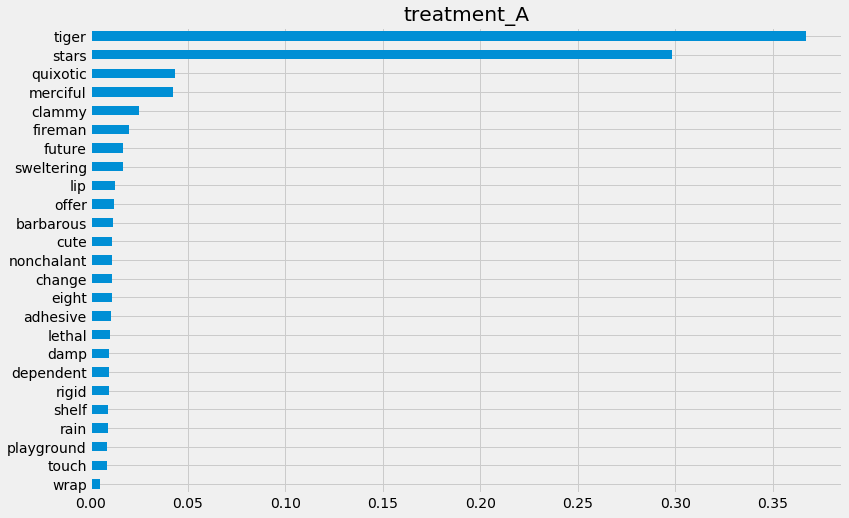

In [29]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [31]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.573731
 stars         0.458209
 merciful      0.036041
 quixotic      0.031509
 clammy        0.016865
 fireman       0.012998
 sweltering    0.011995
 future        0.008679
 lip           0.007420
 offer         0.006272
 eight         0.005664
 barbarous     0.005433
 nonchalant    0.004996
 cute          0.004840
 rain          0.004593
 change        0.004298
 damp          0.004297
 dependent     0.004202
 shelf         0.004026
 lethal        0.003419
 touch         0.003273
 playground    0.003240
 adhesive      0.002401
 wrap          0.001678
 rigid         0.001169
 dtype: float64}

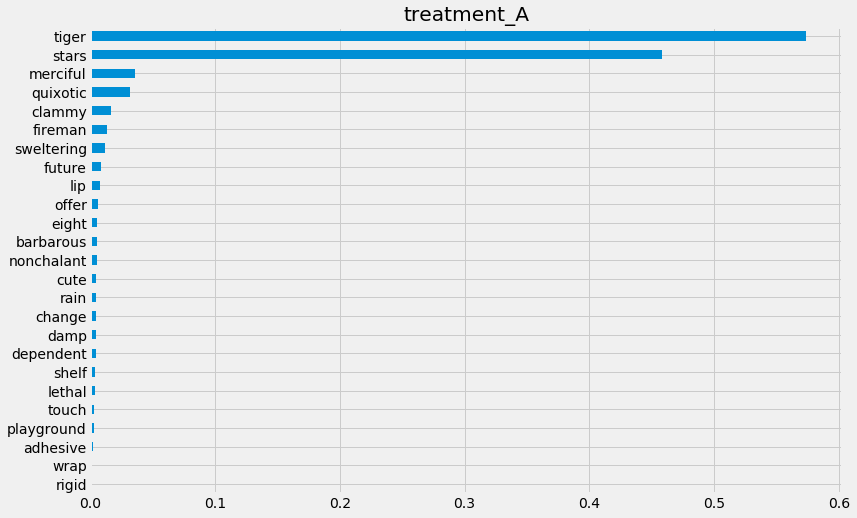

In [32]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [33]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.6249639987945557 seconds


In [34]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.573731
stars         0.458209
merciful      0.036041
quixotic      0.031509
clammy        0.016865
fireman       0.012998
sweltering    0.011995
future        0.008679
lip           0.007420
offer         0.006272
eight         0.005664
barbarous     0.005433
nonchalant    0.004996
cute          0.004840
rain          0.004593
change        0.004298
damp          0.004297
dependent     0.004202
shelf         0.004026
lethal        0.003419
touch         0.003273
playground    0.003240
adhesive      0.002401
wrap          0.001678
rigid         0.001169
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

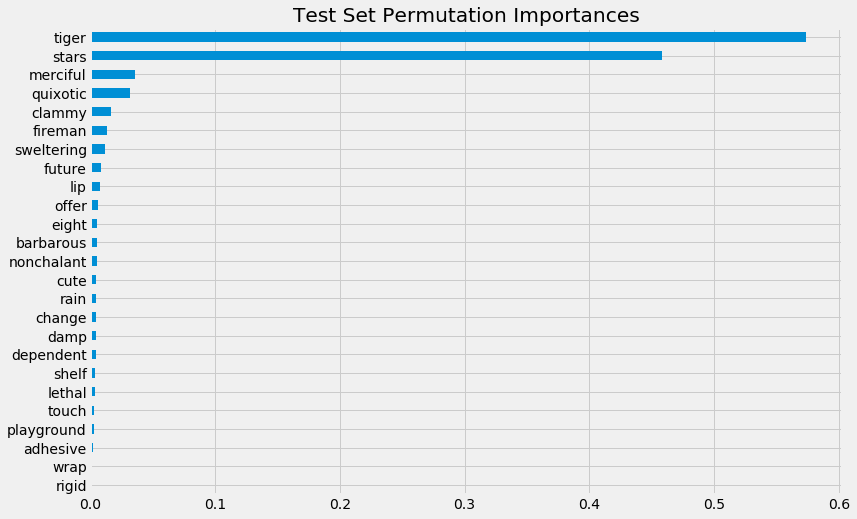

In [35]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [36]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[-6.89269243e-03,  1.40591415e-01,  3.75455659e-03, ...,
          2.64532860e-03, -3.88182312e-03, -7.73279543e-02],
        [ 8.36307028e-02, -2.46364371e-01,  1.09908459e-02, ...,
         -3.66398303e-03, -3.97734276e-03,  2.56495888e-03],
        [ 9.97879884e-02,  1.95474118e-01, -1.57834193e-03, ...,
          3.40626462e-03, -4.85671565e-04, -3.62959648e-03],
        ...,
        [-2.15946344e-01, -1.71168984e-01, -4.55286764e-02, ...,
          2.98283440e-04,  5.74751489e-03,  1.81083170e-02],
        [-8.73306751e-02,  6.44263380e-02, -2.14271236e-02, ...,
         -5.15141325e-03, -3.66708335e-03,  2.43046195e-03],
        [-1.39019231e-01,  4.61741741e-01,  2.16542925e-02, ...,
         -2.78400171e-03,  9.78260008e-03, -3.80018010e-03]])}

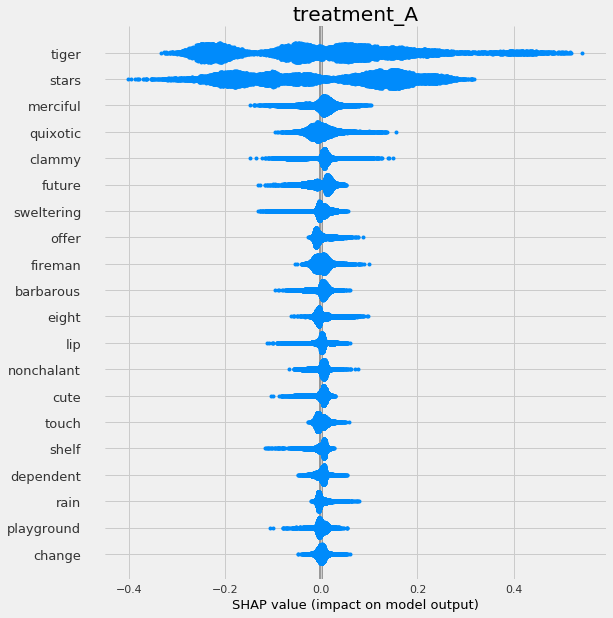

In [37]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

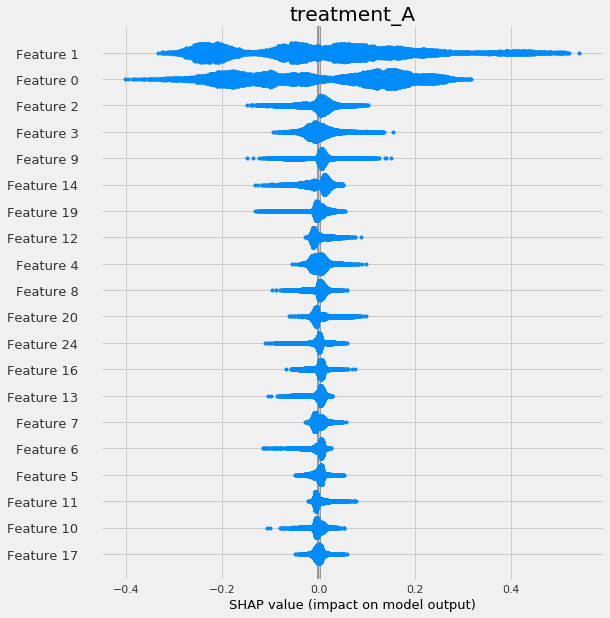

In [38]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(shap_dict=shap_tlearner)

## X Learner

In [39]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, e_multi, w_multi, y)

(array([0.53204758]), array([0.51807698]), array([0.54601818]))

In [40]:
xlearner_tau = xlearner.predict(X, e_multi, w_multi, y)

### Feature Importance (method = `auto`)

In [41]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.445398
 stars         0.350588
 clammy        0.024404
 merciful      0.016463
 eight         0.013235
 quixotic      0.012893
 sweltering    0.012551
 future        0.011300
 touch         0.010797
 nonchalant    0.010058
 offer         0.009685
 barbarous     0.009395
 rain          0.007844
 dependent     0.006987
 fireman       0.006955
 lip           0.006931
 cute          0.006901
 shelf         0.005902
 adhesive      0.005882
 playground    0.005878
 rigid         0.005297
 lethal        0.004445
 damp          0.004319
 change        0.003006
 wrap          0.002885
 dtype: float64}

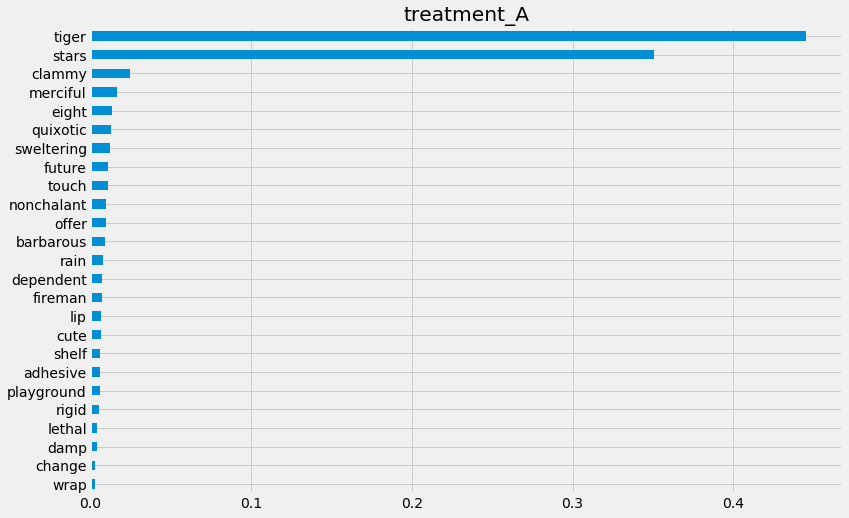

In [42]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [43]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.837614
 stars         0.621791
 clammy        0.035555
 merciful      0.018321
 quixotic      0.015277
 eight         0.013299
 sweltering    0.013252
 touch         0.012349
 nonchalant    0.011482
 barbarous     0.011398
 future        0.010558
 offer         0.009084
 lip           0.008267
 cute          0.008004
 rain          0.006863
 dependent     0.006616
 fireman       0.004964
 rigid         0.004650
 adhesive      0.004461
 shelf         0.004408
 playground    0.004342
 damp          0.003833
 lethal        0.003050
 change        0.002094
 wrap          0.001763
 dtype: float64}

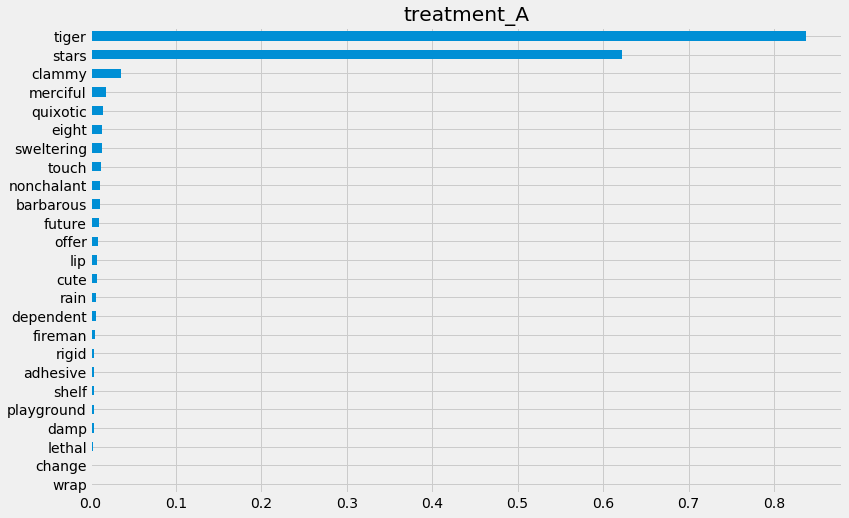

In [44]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [45]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.7079129219055176 seconds


In [46]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.837614
stars         0.621791
clammy        0.035555
merciful      0.018321
quixotic      0.015277
eight         0.013299
sweltering    0.013252
touch         0.012349
nonchalant    0.011482
barbarous     0.011398
future        0.010558
offer         0.009084
lip           0.008267
cute          0.008004
rain          0.006863
dependent     0.006616
fireman       0.004964
rigid         0.004650
adhesive      0.004461
shelf         0.004408
playground    0.004342
damp          0.003833
lethal        0.003050
change        0.002094
wrap          0.001763
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

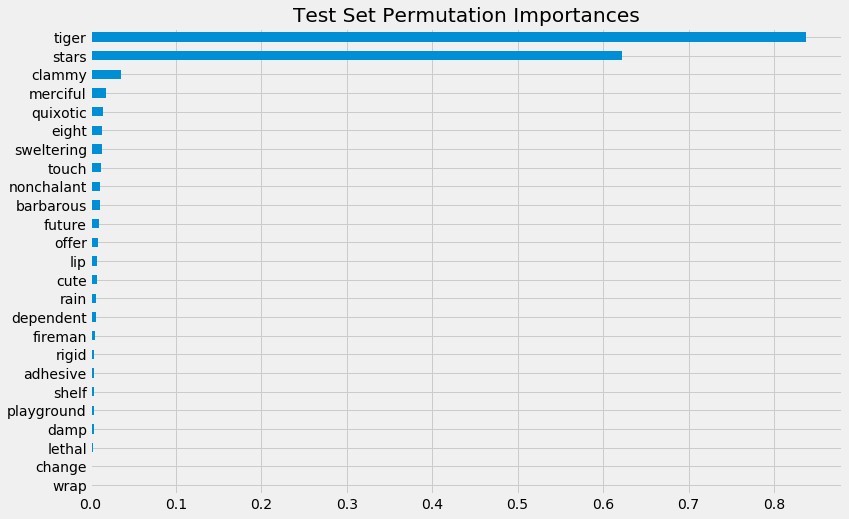

In [47]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [48]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[-0.03485554,  0.15415286,  0.0107788 , ...,  0.00560224,
         -0.00262616, -0.03822558],
        [ 0.08514976, -0.21604149,  0.00567841, ..., -0.00452231,
         -0.00203289,  0.00115042],
        [ 0.09064029,  0.1790326 ,  0.00532089, ..., -0.00343718,
          0.00138747, -0.0012849 ],
        ...,
        [-0.1830646 , -0.13441459, -0.02101109, ...,  0.0104924 ,
          0.0032898 ,  0.01186523],
        [-0.09311651,  0.01577386, -0.0243432 , ..., -0.00377513,
         -0.00081169, -0.00084607],
        [-0.12160697,  0.38320337,  0.01422979, ..., -0.00248256,
          0.0035844 , -0.0038958 ]])}

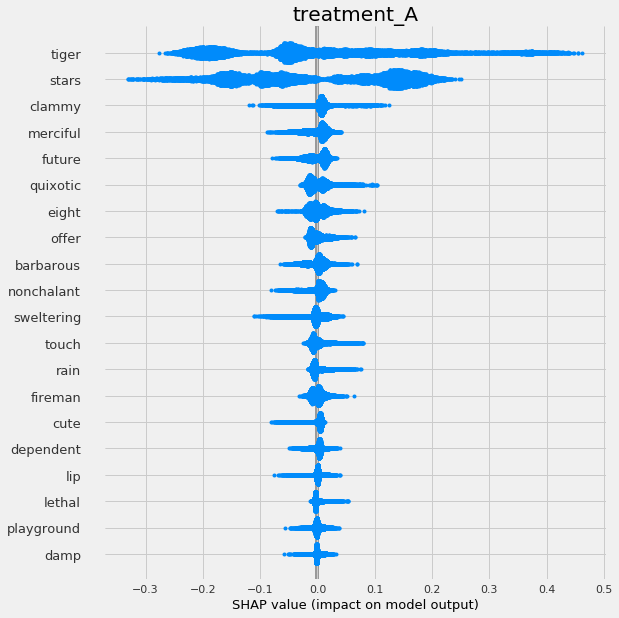

In [49]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

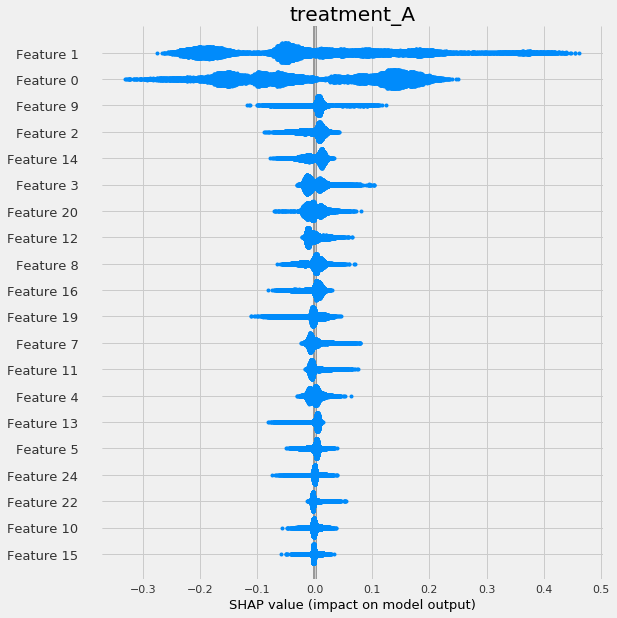

In [50]:
# shap_dict specified
xlearner.plot_shap_values(shap_dict=shap_xlearner)

## R Learner

In [51]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, e_multi, w_multi, y)

### Feature Importance (method = `auto`)

In [52]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.265782
 stars         0.183487
 clammy        0.050748
 sweltering    0.033953
 lip           0.032178
 merciful      0.030900
 future        0.030895
 adhesive      0.028763
 quixotic      0.027381
 offer         0.026122
 rain          0.024693
 cute          0.024653
 eight         0.022138
 touch         0.021480
 rigid         0.020678
 damp          0.020620
 playground    0.018939
 wrap          0.018196
 barbarous     0.018088
 dependent     0.017933
 change        0.017835
 shelf         0.016420
 fireman       0.016152
 nonchalant    0.016051
 lethal        0.015914
 dtype: float64}

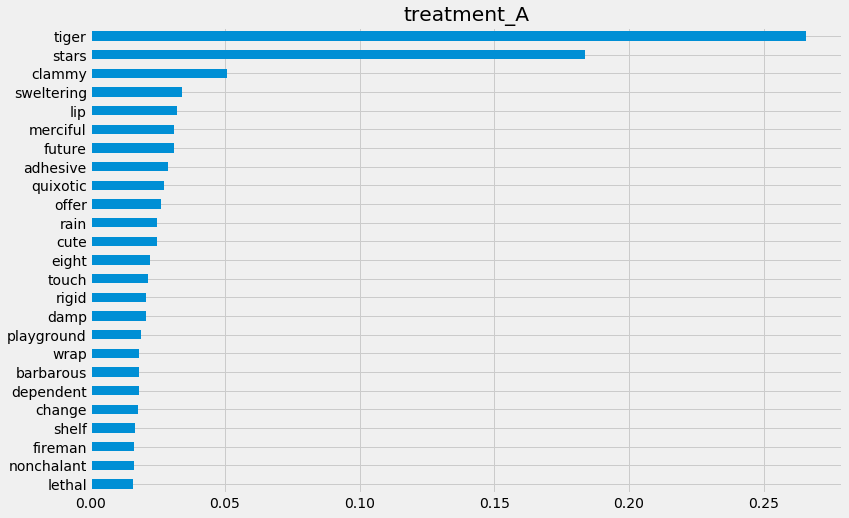

In [53]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [54]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.380958
 stars         0.243383
 clammy        0.044792
 sweltering    0.028370
 lip           0.028354
 future        0.025996
 merciful      0.023391
 offer         0.022393
 adhesive      0.017629
 quixotic      0.017390
 eight         0.015068
 cute          0.015019
 touch         0.012206
 fireman       0.010353
 rain          0.009351
 dependent     0.008820
 playground    0.008726
 nonchalant    0.008371
 barbarous     0.007561
 shelf         0.007027
 lethal        0.006839
 change        0.006731
 wrap          0.005803
 rigid         0.004959
 damp          0.004754
 dtype: float64}

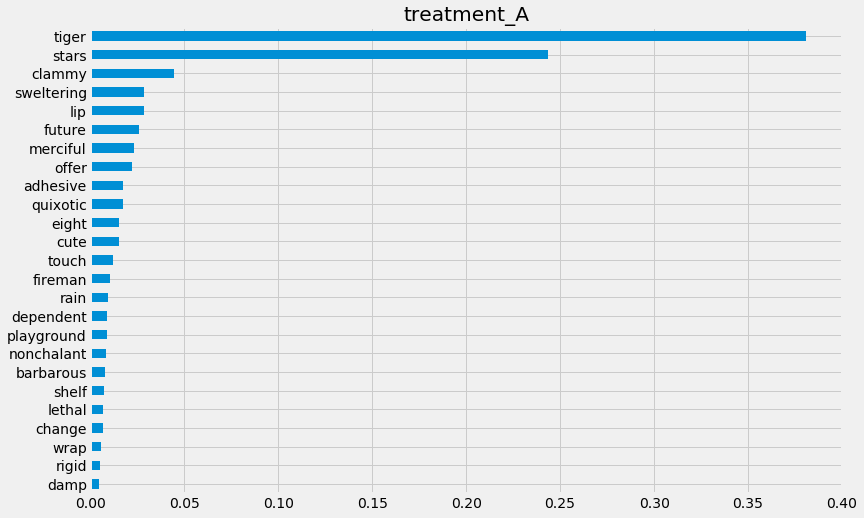

In [55]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [56]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.747636079788208 seconds


In [57]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.380958
stars         0.243383
clammy        0.044792
sweltering    0.028370
lip           0.028354
future        0.025996
merciful      0.023391
offer         0.022393
adhesive      0.017629
quixotic      0.017390
eight         0.015068
cute          0.015019
touch         0.012206
fireman       0.010353
rain          0.009351
dependent     0.008820
playground    0.008726
nonchalant    0.008371
barbarous     0.007561
shelf         0.007027
lethal        0.006839
change        0.006731
wrap          0.005803
rigid         0.004959
damp          0.004754
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

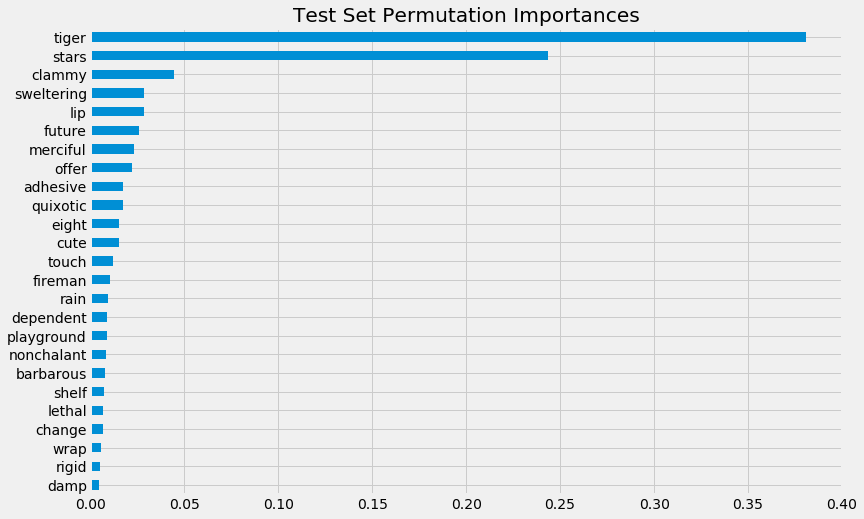

In [58]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [59]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_A': array([[-9.48568815e-03,  1.65557909e-01,  9.65632978e-03, ...,
          6.62268061e-05, -5.09259836e-03, -1.59912241e-01],
        [ 6.55774283e-02, -2.04946202e-01,  1.18588613e-02, ...,
         -7.01146719e-03, -8.74117130e-03,  2.30650966e-03],
        [ 8.02179069e-02,  1.56186874e-01,  8.55430443e-03, ...,
         -7.90951441e-03,  6.48777490e-04, -1.13225597e-02],
        ...,
        [-1.58315449e-01, -1.40714473e-01, -6.53059181e-02, ...,
         -2.63096323e-03, -1.70126307e-02,  4.59584091e-02],
        [-7.90786868e-02,  1.03010179e-02, -3.98414379e-02, ...,
         -7.10201485e-03, -3.18090224e-03,  2.14761644e-03],
        [-1.20000199e-01,  4.60188357e-01,  2.63232980e-02, ...,
         -1.89560835e-02,  1.38353213e-02,  9.37838351e-03]])}

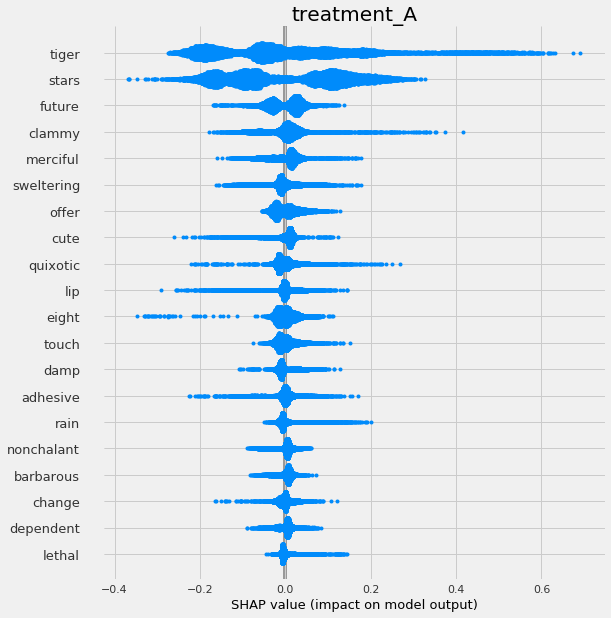

In [60]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

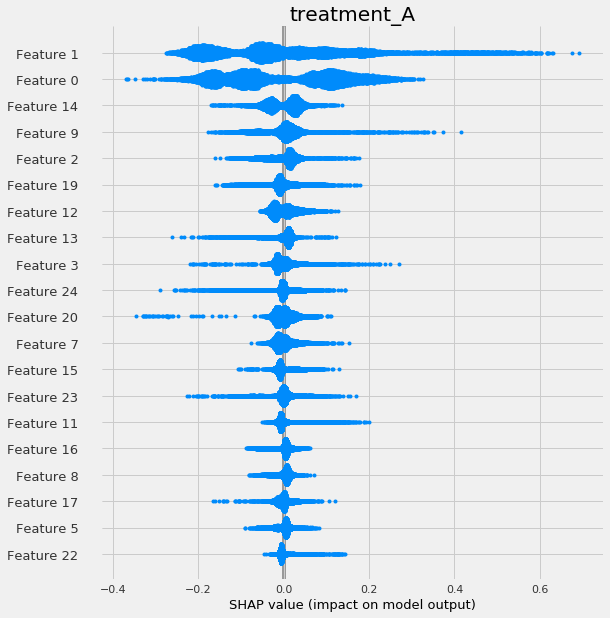

In [61]:
# with providing shap_dict
rlearner.plot_shap_values(shap_dict=shap_rlearner)